In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import numpy as np
import pandas as pd 
import os
from PIL import Image 
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

torch.manual_seed(45)
np.random.seed(45)

cuda:0


In [36]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
props = torch.cuda.get_device_properties(0)
print(props)

1
NVIDIA GeForce RTX 4060
_CudaDeviceProperties(name='NVIDIA GeForce RTX 4060', major=8, minor=9, total_memory=7796MB, multi_processor_count=24, uuid=089b23a4-ea2c-397c-2e09-e0be5e7421ac, pci_bus_id=1, pci_device_id=0, pci_domain_id=0, L2_cache_size=24MB)


In [37]:
# Custom Dataset class modeled after Pytorch dataset. Created to avoid 'class-per-folder' 
# organization that is required by standard pytorch datasets.

# BLAME: Zebulon Mcknight *** 

class DogBreedDataset(Dataset):
    # __init__ receives a pandas dataframe of form ('id')('breed'), a directory
    # containing images, a dict of the form ('breed')(int label), and an optional
    # transform pipeline. 
    def __init__(self, label_df, img_dir, labels, transform=None): 
        self.labels_df = label_df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.classes = labels

    # __len__ simply returns the number of samples in a dataset
    def __len__(self): 
        return len(self.labels_df)
    
    # __getitem__ takes in an index representing an entry in the dataset, it returns the img 
    # and proper class label associated with that index 
    def __getitem__(self, index): 
        row = self.labels_df.iloc[index]
        path = os.path.join(self.img_dir, row["id"]+ ".jpg")
        img = Image.open(path)
        img = img.convert("RGB")

        if self.transform: 
            img = self.transform(img)

        label = self.classes[row['breed']]

        return img, label

In [38]:
# Reading in labels for each image 
# BLAME: Minh Cao *** 
labels = pd.read_csv("data/labels.csv")
breeds = labels['breed'].unique() 

# Dict mapping 'breed' to index, model will operate on integers and we will convert back to breeds 
classes = {b: i for i, b in enumerate(breeds)}

In [39]:
# Data Transformers 

# BLAME: Zebulon Mcknight ***

train_transforms = transforms.Compose([
    transforms.Resize((224,224)), # pytorch expects 224x224 sized images

    # These transformations are standard for introducing more randomness into the training set. 
    # These transformations haven't been tested and perfected individually, but instead
    # come as standard recommended parts of the pipeline for reducing overfitting and promoting
    # generalization 
    transforms.RandomHorizontalFlip(), 
    transforms.RandomResizedCrop(224, scale = (0.8, 1.0)),
    transforms.RandomRotation(15), 
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3), 
    transforms.ToTensor(), 

    # Here we normalize RGB values to the mean and standard deviation of the ImageNet dataset, 
    # the set that our pretrained model was trained on. 
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # pytorch expects 224x224 sized images
    transforms.ToTensor(),

    # Here we normalize RGB values to the mean and standard deviation of the ImageNet dataset, 
    # the set that our pretrained model was trained on. 
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [40]:
# Load all data into a dataset 
# BLAME: Minh Cao *** 
dataset = DogBreedDataset(labels, "data/train", classes, train_transforms)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [41]:
test = DogBreedDataset(labels, "data/test", classes, val_transforms)
test_df = dataset.labels_df

In [42]:
num_classes = len(dataset.classes)

In [43]:
# Split data into training and validation sets stratified by class membership 
# BLAME: Viwesh Gupta
train_df, val_df = train_test_split(dataset.labels_df, 
                                    test_size=0.2, 
                                    stratify=dataset.labels_df['breed'])

#train_df.to_csv("train_split.csv", index=False)
#val_df.to_csv("val_split.csv", index=False)

In [44]:
# Load split data into independent training and validation datasets
# BLAME: Kyle Bomar ***
 
train_dataset = DogBreedDataset(
    label_df=train_df,
    img_dir ='data/train',
    labels = classes,
    transform=train_transforms
)

val_dataset = DogBreedDataset(
    label_df = val_df,
    img_dir ='data/train',
    labels = classes, 
    transform=val_transforms
)

test_dataset = DogBreedDataset(
    label_df = test_df, 
    img_dir ='data/test', 
    labels = classes, 
    transform=val_transforms
)

In [45]:
# Define our dataloaders for training and validation
# BLAME: Kyle Bomar ***

train_loader = DataLoader(
    # these variable primarily affect efficiency at fetching data
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=8, # when running on windows num_worker must equal zero, there is a well known pytorch bug forcing this 
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=8,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False, 
    num_workers=8,
    pin_memory=False
)


In [46]:
# Test if the dataset itself is working
# BLAME: Viwesh Gupta ***
for i in range(3):
    try:
        x, y = train_dataset[i]
        print(f"Item {i}: Image shape = {x.shape}, Label = {y}")
    except Exception as e:
        print(f"Error at index {i}: {e}")


Item 0: Image shape = torch.Size([3, 224, 224]), Label = 68
Item 1: Image shape = torch.Size([3, 224, 224]), Label = 79
Item 2: Image shape = torch.Size([3, 224, 224]), Label = 14


In [47]:
# DEFINING MODEL SPECIFICATIONS

# BLAME: Zebulon Mcknight and Minh Cao***

# This line represents our model. For this implementation we are 
# using resnet18 with weights pretrained on ImageNetV1. This is an
# industry standard Convolutional Neural Network designed for image
# classification. 
cnn = models.resnet18(weights="IMAGENET1K_V1")

# Here we freeze all but the last layer of the cnn, this lets us
# start from a good place for image classification but lets us
# design our own final layer for predictions. 
for param in cnn.parameters(): 
    param.requires_grad = False

# Our final layer. This resembles a 2 layer MLP (multi layer perceptron)
# That maps the hundreds or thousands of features present in the CNN 
# to the 120 outputs that we need to map to class probabilities. This layer is 
# the only layer we are training in our training loop. 
cnn.fc = nn.Sequential(
    nn.Linear(cnn.fc.in_features, 256), 
    nn.ReLU(), 
    nn.Dropout(0.5), # Using dropout will hurt training performance, but decrease overfitting 
    nn.Linear(256, num_classes)
)

cnn=cnn.to(device)
print(cnn)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [48]:
criterion = nn.CrossEntropyLoss() # we'll be using CrossEntropy loss 
# This is our optimizer, ADAM is similar to an improved verison of stochastic 
# gradient descent designed specifically for deep learning
optimizer = optim.Adam(cnn.fc.parameters(), lr=1e-3, weight_decay=1e-4) 

In [ ]:
# TRAINING LOOP 

# BLAME: Zebulon Mcknight ***

# Our training function takes in a reference to our model, our training and validation
# loaders, a loss function, an optimizer, and a number of epochs to train for 
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, unfreeze=False, schedule=None): 
    train_losses = []
    val_losses = []
    accuracy = []

    print(f"Optimizer now has {len([p for g in optimizer.param_groups for p in g['params']])} params")

    for epoch in range(num_epochs): 
        if unfreeze == True and epoch in schedule: 
            unfreeze_layer(model, schedule[epoch])
            print(f"Unfroze {schedule[epoch]}")

            old_params = [p for group in optimizer.param_groups for p in group['params']]
            new_params = [p for p in model.parameters() if p.requires_grad and not any(p is x for x in old_params)]

            if new_params: 
                optimizer.add_param_group({'params': new_params})

            print(f"Optimizer now has {len([p for g in optimizer.param_groups for p in g['params']])} params")

        model.train()

        # We will track loss and accuracy for each epoch 
        running_loss = 0.0
        running_corrects = 0

        # each epoch is broken into batches of 64 images
        for inputs, labels in tqdm(train_loader): 
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs,1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss} | Accuracy: {epoch_acc}")

        train_losses.append(epoch_loss)

        # Validation loop
        # BLAME: Kyle Bomar ***
         
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad(): 
            for inputs, labels in val_loader: 
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += (preds == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss} | Accuracy: {val_acc}")

        val_losses.append(val_loss)
        accuracy.append(val_acc)

    return accuracy, train_losses, val_losses 


In [50]:
def unfreeze_layer(model, layers): 
    for name, param in model.named_parameters(): 
        if any(name.startswith(layer) for layer in layers): 
            param.requires_grad = True

        #if param.requires_grad:
            #print(f"{name} is trainable")

In [18]:
def evaluate(model, test_loader): 
    model.eval()
    predictions = []

    with torch.no_grad(): # do not use gradients when testing 
        for inputs in test_loader: 
            inputs = inputs.to(device)
            outputs = model(inputs)

            # make a prediction, convert it to numpy, and track it for submission 
            _, prediction = torch.max(outputs, 1)
            prediction = prediction.numpy()

            for sample in prediction: 
                predictions.append(sample)
            

    return np.array(predictions)

In [19]:
torch.set_num_threads(os.cpu_count())
print(os.cpu_count())

28


In [51]:
unfreezing_schedule = {
    1:["layer4"], 
    2:["layer3"], 
    3:["layer2"]
}

In [56]:
val_acc, train_loss, val_loss = train(cnn, train_loader, val_loader, criterion, optimizer, num_epochs=5, unfreeze=True, schedule=unfreezing_schedule)

Optimizer now has 4 params


100%|██████████| 128/128 [00:16<00:00,  7.61it/s]

Epoch 1/5 | Train Loss: 2.036843181414521 | Accuracy: 0.4298642533936652


Validation Loss: 1.3283029784200244 | Accuracy: 0.6508557457212714
Unfroze ['layer4']


RuntimeError: The size of tensor a (512) must match the size of tensor b (3) at non-singleton dimension 3

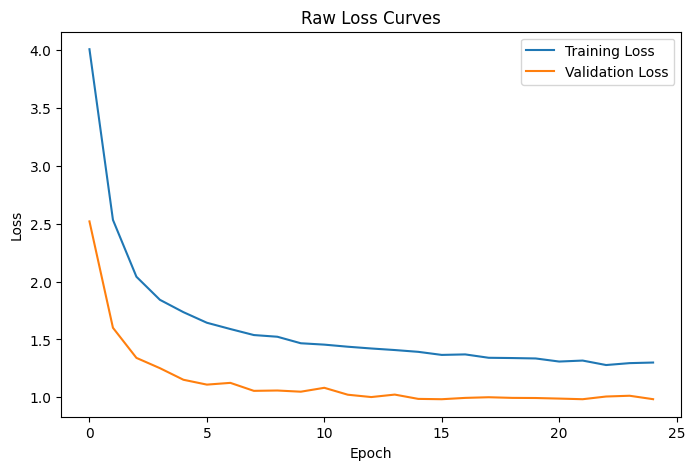

In [80]:
fig = plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Raw Loss Curves')
plt.legend()
plt.show()
fig.savefig("results_figures/51520_loss.jpg")

In [81]:
train_loss = np.array(train_loss)
cum_train_loss = np.cumsum(train_loss)
avg_train_loss = cum_train_loss / np.arange(1, len(train_loss) + 1)

val_loss = np.array(val_loss)
cum_val_loss = np.cumsum(val_loss)
avg_val_loss = cum_val_loss / np.arange(1, len(val_loss) + 1)

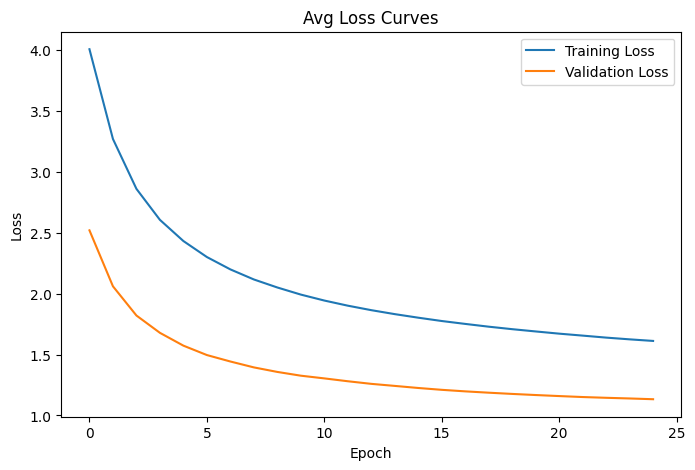

In [82]:
fig = plt.figure(figsize=(8,5))
plt.plot(avg_train_loss, label='Training Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Avg Loss Curves')
plt.legend()
plt.show()
fig.savefig("results_figures/51520_avg_loss.jpg")

In [26]:
import optuna

/home/zmcknigh/cs325_final/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def hyperparam_search(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    reg = trial.suggest_float("weight_decay", 1e-6, 1e-1, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.6)
    
    model = build_model(dropout)
    model.to(device)

    val_loss, val_acc = train_and_eval(model, train_loader, val_loader, lr, reg)

    trial.set_user_attr("val_acc", val_acc)
    return val_loss
    

def build_model(dropout): 
    model = models.resnet18(weights="IMAGENET1K_V1")

    for param in model.parameters(): 
        param.requires_grad = False

    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256), 
        nn.ReLU(), 
        nn.Dropout(dropout), # Using dropout will hurt training performance, but decrease overfitting 
        nn.Linear(256, 120)
    )

    return model

def train_and_eval(model, train_loader, val_loader, lr, wd):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                           lr=lr, weight_decay=wd)

    for _ in range(3):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

    # Validation performance (metric Optuna minimizes)
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            val_loss += criterion(logits, y).item()
            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)

    return val_loss / len(val_loader), correct / total


In [29]:
study = optuna.create_study(direction="minimize")
study.optimize(hyperparam_search, n_trials=15)

[I 2025-11-19 08:39:29,740] A new study created in memory with name: no-name-06087852-c621-457d-97d0-db83b29433d6
[W 2025-11-19 08:40:22,378] Trial 0 failed with parameters: {'lr': 0.018359550522892457, 'weight_decay': 4.1639859264020165e-06, 'dropout': 0.26169806484697683} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/zmcknigh/cs325_final/.venv/lib64/python3.9/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_3244694/4055521281.py", line 9, in hyperparam_search
    val_loss, val_acc = train_and_eval(model, train_loader, val_loader, lr, reg)
  File "/tmp/ipykernel_3244694/4055521281.py", line 53, in train_and_eval
    val_loss += criterion(logits, y).item()
KeyboardInterrupt
[W 2025-11-19 08:40:22,382] Trial 0 failed with value None.


KeyboardInterrupt: 

In [49]:
model_state = cnn.state_dict()

torch.save(model_state, "model_1.0")

In [ ]:
# load trained model from storage
state_dict = torch.load("model_1.0", map_location=device)
cnn.load_state_dict(state_dict)

<All keys matched successfully>